In [1]:
!pip install lipstick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 7.4 MB/s 
     |████████████████████████████████| 3.2 MB 42.0 MB/s 
     |████████████████████████████████| 965 kB 47.4 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.datasets import make_moons, make_swiss_roll
from lipstick import GifMaker

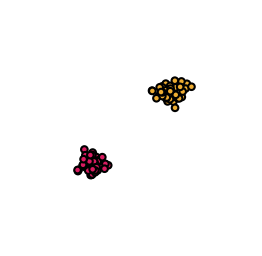

In [2]:
x_0_mog = np.concatenate([
    np.random.normal(loc=-1, scale=0.2, size=(50, 2)),
    np.random.normal(loc=1, scale=0.2, size=(50, 2))
])
x_0_mog = torch.Tensor(x_0_mog)

c_mog = np.concatenate([
    np.zeros((50, )),
    np.ones((50, )),
])

color = ['#D81B60'] * 50 + ['#EDAC32'] * 50

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
ax.scatter(*x_0_mog.T, s=10, c=color, edgecolor='k')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
plt.show()

In [47]:
class NN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = torch.nn.Linear(5, 100)
    self.fc2 = torch.nn.Linear(100, 100)
    self.fc3 = torch.nn.Linear(100, 2)
    self.relu = torch.nn.ReLU()

  def forward(self, x, t, c):
    inp = torch.cat([x, t.repeat(x.shape[0]).unsqueeze(1), c], dim=1)
    out = self.fc1(inp)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out

In [48]:
from tqdm import tqdm
import torch.nn.functional as F

mog_net = NN()
optimizer = torch.optim.Adam(mog_net.parameters())

epochs = 10000
pbar = tqdm(range(epochs))

beta = 0.01
alpha = 1 - beta
T = 20
mse = torch.nn.MSELoss()

def get_alpha_bar(alpha, t):
  """
  We assume a constant value of alpha
  """
  return alpha ** t

mog_ls = []
for i in pbar:
  optimizer.zero_grad()

  bs = x_0_mog.shape[0]
  t = torch.randint(0, T, size=(1, ))
  alpha_bar = get_alpha_bar(alpha, T - t)
  eps = torch.randn(bs, 2)
  corrupted_x = torch.sqrt(alpha_bar) * x_0_mog + torch.sqrt(1 - alpha_bar) * eps

  c_mog_one_hot = F.one_hot(torch.LongTensor(c_mog), 2) * torch.randint(0, 2, size=(c_mog.shape[0], 1))

  # c_mog_masked = torch.Tensor(c_mog + 1) * torch.randint(0, 2, size=(c_mog.shape[0], ))
  # c_mog_masked = torch.Tensor(c_mog_masked).unsqueeze(1)

  eps_pred = mog_net(corrupted_x, t, c_mog_one_hot)

  loss = mse(eps, eps_pred)
  loss.backward()

  optimizer.step()

  mog_ls.append(loss.item())

  pbar.set_description(f'{loss.item():.4f}')

0.2822: 100%|██████████| 10000/10000 [00:56<00:00, 176.68it/s]


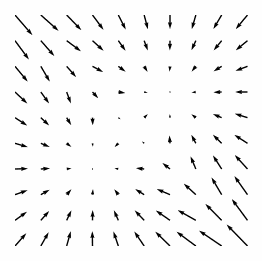

In [49]:
import numpy as np
import matplotlib
matplotlib.rc_file_defaults()

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("diffusion_results_gradient.gif", fps=10) as g:
  for t in list(range(1, 30)):
    eps = -mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x.shape[0], 1)).detach().numpy()

    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    plt.close()
    g.add(fig)

g.show()

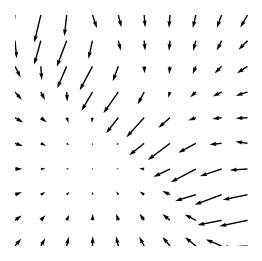

In [59]:
import numpy as np
import matplotlib
matplotlib.rc_file_defaults()

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("diffusion_results_gradient.gif", fps=10) as g:
  for t in list(range(1, 30)):
    eps_0 = mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x.shape[0], 1)).detach().numpy()
    eps_1 = mog_net(x, torch.Tensor([t]), torch.Tensor([[1, 0]]).repeat(x.shape[0], 1)).detach().numpy()
    s = 3
    eps = eps_1 + s * (eps_1 - eps_0)
    eps = -eps

    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    plt.close()
    g.add(fig)

g.show()

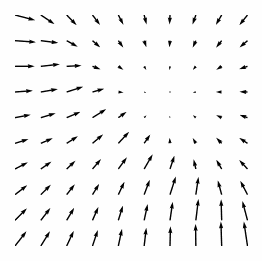

In [60]:
import numpy as np
import matplotlib
matplotlib.rc_file_defaults()

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("diffusion_results_gradient.gif", fps=10) as g:
  for t in list(range(1, 30)):
    eps_0 = mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x.shape[0], 1)).detach().numpy()
    eps_1 = mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 1]]).repeat(x.shape[0], 1)).detach().numpy()
    s = 1
    eps = eps_1 + s * (eps_1 - eps_0)
    eps = -eps

    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    plt.close()
    g.add(fig)

g.show()

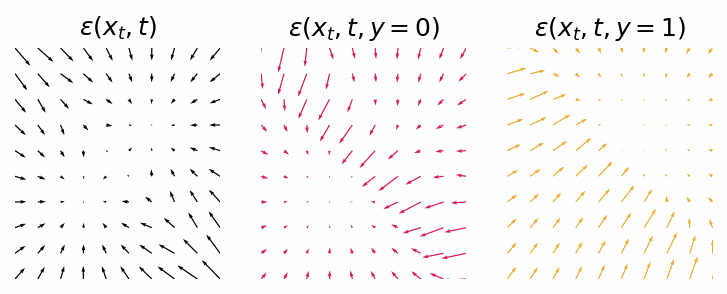

In [66]:
import numpy as np
import matplotlib
matplotlib.rc_file_defaults()

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("diffusion_gradients_free.gif", fps=10) as g:
  for t in list(range(1, 30)):
    fig, axs = plt.subplots(1, 3, figsize=(6, 2), dpi=150)
    ax = axs[0]

    eps = -mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x.shape[0], 1)).detach().numpy()

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    
    ax.set_title('$\epsilon(x_t, t)$')

    ax = axs[1]

    eps_0 = mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x.shape[0], 1)).detach().numpy()
    eps_1 = mog_net(x, torch.Tensor([t]), torch.Tensor([[1, 0]]).repeat(x.shape[0], 1)).detach().numpy()
    s = 3
    eps = eps_1 + s * (eps_1 - eps_0)
    eps = -eps

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1], color='#D81B60')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    
    ax.set_title('$\epsilon(x_t, t, y=0)$')

    ax = axs[2]

    eps_0 = mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x.shape[0], 1)).detach().numpy()
    eps_1 = mog_net(x, torch.Tensor([t]), torch.Tensor([[0, 1]]).repeat(x.shape[0], 1)).detach().numpy()
    s = 3
    eps = eps_1 + s * (eps_1 - eps_0)
    eps = -eps

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1], color='#EDAC32')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    
    ax.set_title('$\epsilon(x_t, t, y=1)$')

    g.add(fig)

g.show()

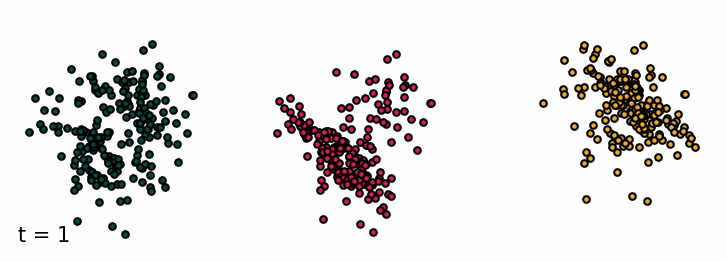

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
x_t = torch.randn(200, 2)

x_mog = x_t.clone()
x_mog_0 = x_t.clone()
x_mog_1 = x_t.clone()

with GifMaker("diffusion_free_guided_results.gif", fps=10) as g:
  for t in list(range(1, 30)):
    z = torch.randn(x_t.shape[0], 2)

    fig, axs = plt.subplots(1, 3, figsize=(6, 2), dpi=150)

    eps_0 = mog_net(x_mog, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x_mog.shape[0], 1)).detach().numpy()
    eps = eps_0

    x_mog = 1/np.sqrt(alpha) * (x_mog - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * eps) + beta * z
    
    ax = axs[0]
    ax.scatter(*x_mog.T, s=10, c='#004D40', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = {t}')

    eps_0 = mog_net(x_mog_0, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x_mog.shape[0], 1)).detach().numpy()
    eps_1 = mog_net(x_mog_0, torch.Tensor([t]), torch.Tensor([[1, 0]]).repeat(x_mog.shape[0], 1)).detach().numpy()
    s = 3
    eps = eps_1 + s * (eps_1 - eps_0)

    x_mog_0 = 1/np.sqrt(alpha) * (x_mog_0 - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * eps) + beta * z
    
    ax = axs[1]
    ax.scatter(*x_mog_0.T, s=10, c='#D81B60', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    eps_0 = mog_net(x_mog_1, torch.Tensor([t]), torch.Tensor([[0, 0]]).repeat(x_mog.shape[0], 1)).detach().numpy()
    eps_1 = mog_net(x_mog_1, torch.Tensor([t]), torch.Tensor([[0, 1]]).repeat(x_mog.shape[0], 1)).detach().numpy()
    s = 3
    eps = eps_1 + s * (eps_1 - eps_0)

    x_mog_1 = 1/np.sqrt(alpha) * (x_mog_1 - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * eps) + beta * z

    ax = axs[2]
    ax.scatter(*x_mog_1.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    g.add(fig)

  for _ in range(5):
    fig, axs = plt.subplots(1, 3, figsize=(6, 2), dpi=150)
    ax = axs[0]
    ax.scatter(*x_mog.T, s=10, c='#004D40', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    ax.text(-2.9, -2.9, f't = 30')

    ax = axs[1]
    ax.scatter(*x_mog_0.T, s=10, c='#D81B60', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax = axs[2]
    ax.scatter(*x_mog_1.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    g.add(fig)

g.show()